In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

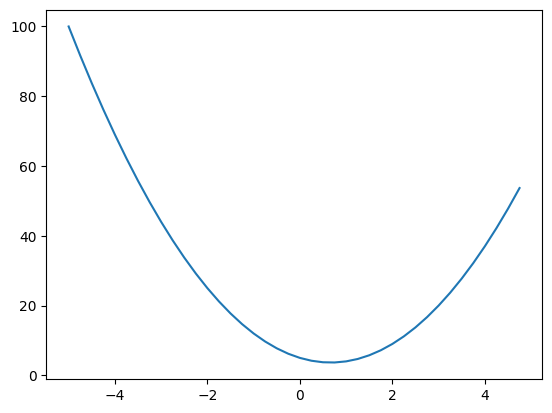

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 2/3
df = (f(x+h) - f(x))/h
df

2.9753977059954195e-07

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h, '\n')

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062 

d1 4.0
d2 4.00002
slope 2.0000000000131024


## Start with neural network

In [8]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data + self.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data * self.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = Left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %0.4f | grad %0.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Neural net with 2 inputs  

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()

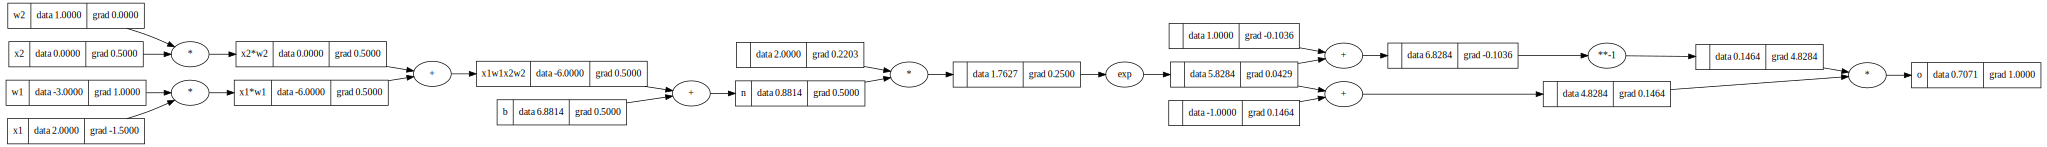

In [11]:
draw_dot(o)

In [12]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w,x)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [13]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
n = MLP(3, [4,4,1])

In [15]:
len(n.parameters())

41

In [16]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [17]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 4.738683025069416
1 2.3221007788878913
2 1.2691300928487368
3 0.7121268040388109
4 0.4339111107521798
5 0.30245651873970264
6 0.230151010825914
7 0.18442362989717928
8 0.15323479772644358
9 0.13073678669583896
10 0.11380107045092838
11 0.10062153288177879
12 0.09008952472537798
13 0.08148967340276622
14 0.07434097057967648
15 0.06830867445314791
16 0.063152957165166
17 0.05869766406447385
18 0.0548105971170198
19 0.05139066881207091


In [18]:
ypred 

[Value(data=0.8864104819296829),
 Value(data=-0.8853943795929053),
 Value(data=-0.8980916692675044),
 Value(data=0.877654856675693)]